# I. Preparation

In [44]:
import os
import h5py
import time
import itertools

from math import log, sqrt
from statistics import stdev, variance, mean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
from scipy.stats import ttest_ind, ttest_1samp

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

from fooof import FOOOF, FOOOFGroup
from fooof.plts.spectra import plot_spectrum, plot_spectrum_shading, plot_spectra, plot_spectra_shading
from fooof.analysis import get_band_peak_fm, get_band_peak_fg
from fooof.plts.periodic import plot_peak_fits, plot_peak_params
from fooof.plts.aperiodic import plot_aperiodic_params, plot_aperiodic_fits
from fooof.objs.utils import combine_fooofs

from neurodsp.filt import filter_signal
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum

## 1. Function to read .mat files

In [45]:
def read_matlab(filename):
    def conv(path=''):
        p = path or '/'
        paths[p] = ret = {}
        for k, v in f[p].items():
            if type(v).__name__ == 'Group':
                ret[k] = conv(f'{path}/{k}')  # Nested struct
                continue
            v = v[()]  # It's a Numpy array now
            if v.dtype == 'object':
                # HDF5ObjectReferences are converted into a list of actual pointers
                ret[k] = [r and paths.get(f[r].name, f[r].name) for r in v.flat]
            else:
                # Matrices and other numeric arrays
                ret[k] = v if v.ndim < 2 else v.swapaxes(-1, -2)
        return ret

    paths = {}
    with h5py.File(filename, 'r') as f:
        return conv()

## 2. Parameters that can be changed

In [46]:
# Days
days = ('/Day1', '/Day2')

# Subjects
subjects = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 
            'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 
            'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30']

In [47]:
# Parieto, parieto-occipital and occipital channels
channels = (17,18,19,20,21,22,23,24,25,26,27,29,30)
n_channels = 13

In [48]:
table = 2

# Frequency range to fit FOOOF model: Low, Mid, or High
fr = (3,20)

# Frequency range from which to collect Gaussians
bn = (3,9)

## 3. Parameters that should stay fixed

In [49]:
# Sampling rate
fs = 200

# nperseg
nperseg = 500

# Set peak_width_limits
pwl = [2, 4]

# Set max_n_peaks
mnp = 5

# Set peak_threshold
pt = 2 

# Initialize dataframe to store variables
df = pd.DataFrame([], index = [], columns = ['subject', 'day', 'target', \
                                             'offset', 'knee', 'exponent', \
                                             'CF', 'PW', 'BW', 'n_peaks', \
                                             'r_squared', 'error'])

# Colors
colors = ['blue', 'yellow', 'green', 'red']

# II. Fourier transform and FOOOF

In [50]:
## Read EEG, calculate PSD (Welch), fit FOOOF

tic = time.time()
for subject in subjects: 
    for day in days:
        # Initialize per target, average over trials and channels
        powers_50 = np.empty((0, int(nperseg//2)+1), float)
        powers_55 = np.empty((0, int(nperseg//2)+1), float)
        powers_60 = np.empty((0, int(nperseg//2)+1), float)
        powers_65 = np.empty((0, int(nperseg//2)+1), float)
        powers_210 = np.empty((0, int(nperseg//2)+1), float)
        powers_215 = np.empty((0, int(nperseg//2)+1), float)
        powers_220 = np.empty((0, int(nperseg//2)+1), float)
        powers_225 = np.empty((0, int(nperseg//2)+1), float)
        powers_400 = np.empty((0, int(nperseg//2)+1), float)
        powers_405 = np.empty((0, int(nperseg//2)+1), float)
        powers_410 = np.empty((0, int(nperseg//2)+1), float)
        powers_415 = np.empty((0, int(nperseg//2)+1), float)

        # Change working directory
        original = os.getcwd()
        os.chdir("C:/Users/ThinkPad/Desktop/Thesis/Data/"+subject+day)

        # Giving directory name
        folderdir = 'C:/Users/ThinkPad/Desktop/Thesis/Data/'+subject+day

        # Giving file extensions
        ext = ('.mat')

        # Iterating over directory
        for path, dirc, files in os.walk(folderdir):
            for file in files:
                if file.endswith(ext) and file.startswith('cnt'):
                    print(subject, day, file)

                    # LOW, MID, or HIGH
                    level = file[4:-7]

                    # Session 1, or session 2
                    session = file[-6]

                    # Read data
                    data = read_matlab(file)['cnt']['x']

                    # Read timestamps 
                    timestamps = (read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['time'])[0]

                    # Read stimuli order
                    order_stimuli = read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['event']['desc']

                    for trial, timestamp in enumerate(timestamps): 
                        if trial%2 == False:
                            start = int(timestamp)
                        else:
                            stop = int(timestamp)

                            for channel in channels:
#                                 # Apply bandpass filter
#                                 data[:,channel] = filter_signal(data[:,channel], fs, 'bandpass', f_range=fr)
                                    
                                # Splice data according to timestamps
                                sig = data[:,channel][start:stop]
                                times = create_times(len(sig)/fs, fs)

#                                 # Plot EEG 
#                                 fig, ax = plt.subplots(figsize=[15, 5])
#                                 plot_time_series(times, sig, xlim=[0,len(sig)/fs], ax=ax)
#                                 plt.show()                                

                                # Welch FFT: calculate mean of spectrogram
                                freq, power = signal.welch(sig, fs, window='hann', average='mean', nperseg=nperseg,\
                                                          noverlap=450, detrend='constant')

                                # Append power to previous powers
                                if level=='LOW':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_50 = np.append(powers_50, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_55 = np.append(powers_55, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_60 = np.append(powers_60, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_65 = np.append(powers_65, power.reshape(1, len(freq)), axis=0)
                                elif level=='MID':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_210 = np.append(powers_210, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_215 = np.append(powers_215, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_220 = np.append(powers_220, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_225 = np.append(powers_225, power.reshape(1, len(freq)), axis=0)
                                elif level=='HIGH':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_400 = np.append(powers_400, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_405 = np.append(powers_405, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_410 = np.append(powers_410, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_415 = np.append(powers_415, power.reshape(1, len(freq)), axis=0)

        # Fit FOOOF model per target
        for (powers, target) in zip((powers_50, powers_55, powers_60, powers_65), \
                                    (50, 55, 60, 65)):
            # FOOOF object: initialize, fit and print results
            fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
            fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
            fm.print_results()
#             fig, ax = plt.subplots(figsize=[15, 5])
#             fm.plot(plot_peaks='line-shade', ax=ax)
#             plt.show()

            # Save metadata, FOOOF parameters and results
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=True)[0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass

# Typecast dataframe
df[['subject', 'day', 'target']] = df[['subject', 'day', 'target']].astype('category')
df['n_peaks'] = df['n_peaks'].astype('int32')
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']] = \
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']].astype('float32')

# Change working directory back
os.chdir(original)

print(f'Done in {time.time()-tic} seconds')

S1 /Day1 cnt_HIGH(1).mat
S1 /Day1 cnt_HIGH(2).mat
S1 /Day1 cnt_LOW(1).mat
S1 /Day1 cnt_LOW(2).mat
S1 /Day1 cnt_MID(1).mat
S1 /Day1 cnt_MID(2).mat
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     2.4872, 102.6628, 2.0745                                     
                                                              

C:\Users\ThinkPad\anaconda3\lib\site-packages\fooof\core\funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


S27 /Day1 cnt_HIGH(2).mat
S27 /Day1 cnt_LOW(1).mat
S27 /Day1 cnt_LOW(2).mat
S27 /Day1 cnt_MID(1).mat
S27 /Day1 cnt_MID(2).mat
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     1.6698, -0.9244, 1.4792                                      
                                                                                  

# III. Descriptive statistics
## 1. Summary

In [51]:
# Data types
display(df.dtypes)

subject      category
day          category
target       category
offset        float32
knee          float32
exponent      float32
CF            float32
PW            float32
BW            float32
n_peaks         int32
r_squared     float32
error         float32
dtype: object

In [52]:
# Head of dataframe
display(df.head(n=5))

,subject,day,target,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
0,S1,/Day1,60,2.575504,110.889587,2.066221,6.448652,0.131256,2.0,4,0.875963,0.084074
1,S1,/Day2,50,2.476227,79.799011,2.106115,7.446962,0.205194,2.0,2,0.955792,0.076776
2,S1,/Day2,60,2.637844,134.310135,2.155900,6.389362,0.086946,2.0,3,0.963514,0.068488
3,S1,/Day2,65,3.130147,397.794403,2.751113,8.928272,0.485694,2.0,3,0.948914,0.087213
4,S2,/Day1,50,2.238204,25.191677,1.865300,5.989741,0.577807,2.0,2,0.914587,0.101412


In [53]:
# Summary statistics
display(pd.concat([df.describe(),\
                   pd.DataFrame(df.skew(), columns=['skewness']).transpose(),\
                   pd.DataFrame(df.kurtosis(), columns=['kurtosis']).transpose()]).round(2))

,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
count,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00
mean,2.93,217324.19,2.43,6.67,0.31,2.08,2.07,0.93,0.07
std,1.58,1523910.25,1.18,1.05,0.18,0.35,0.69,0.06,0.03
min,-0.37,-2.12,0.11,3.20,0.03,2.00,1.00,0.68,0.03
25%,1.87,6.84,1.65,5.99,0.19,2.00,2.00,0.92,0.05
50%,2.84,126.52,2.35,6.44,0.27,2.00,2.00,0.95,0.07
75%,3.75,694.93,3.06,6.90,0.40,2.00,3.00,0.97,0.09
max,7.96,16731123.00,5.99,8.97,0.87,4.00,4.00,0.99,0.15
skewness,0.78,9.71,0.65,0.59,0.76,4.33,0.04,-2.51,0.87
kurtosis,0.90,101.96,0.31,1.07,0.17,18.30,-0.50,7.41,0.38


## 2. Univariate plots

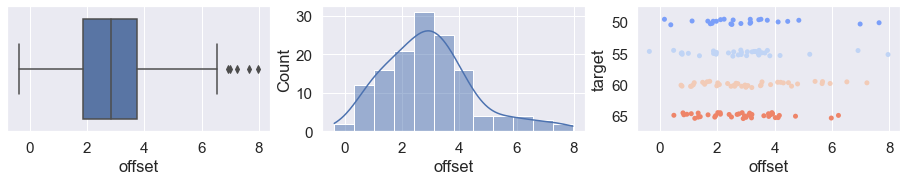

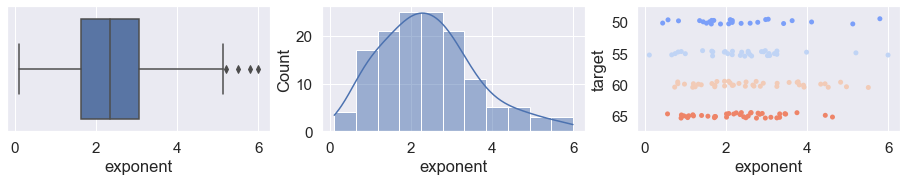

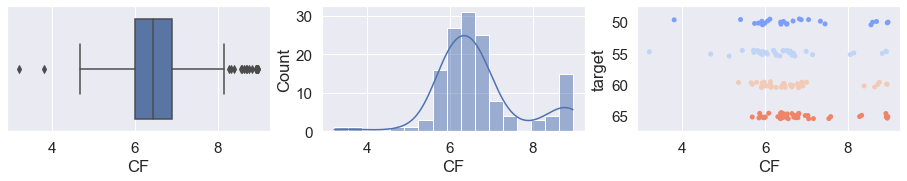

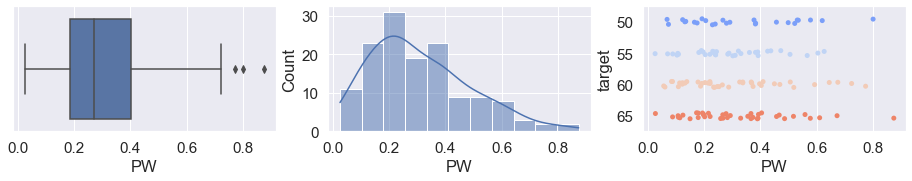

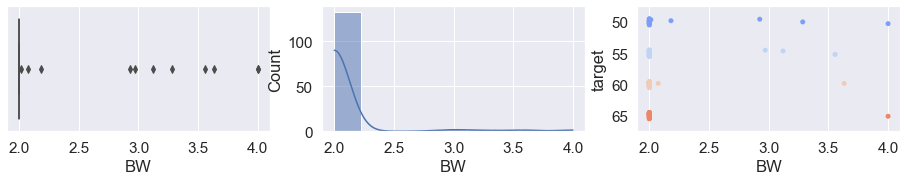

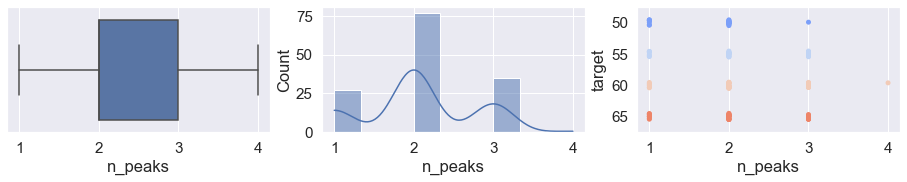

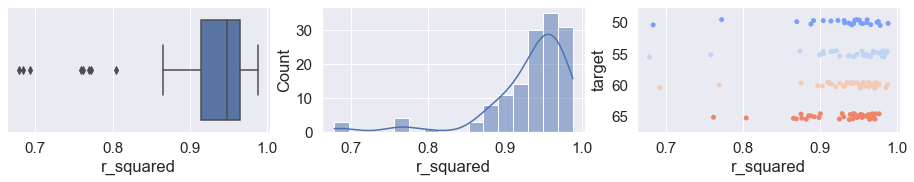

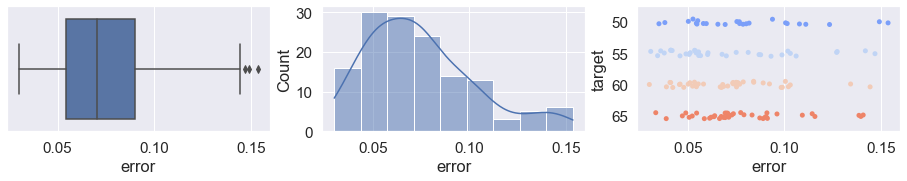

Done in 11.441s


In [54]:
tic = time.time()

df_num = df[['offset', 'exponent', 'CF', 'PW', 'BW', 'n_peaks', 'r_squared', 'error']]

for index, column in enumerate(df_num):
    sns.set(font_scale = 1.38)
    fig, ax = plt.subplots(1, 3, figsize=[16, 2.3])
    sns.boxplot(data=df_num, x=column, ax=ax[0])
    sns.histplot(data=df_num, x=column, kde=True,  ax=ax[1]) 
    sns.stripplot(data=df_num, x=column, y=df['target'], palette='coolwarm', ax=ax[2])
    plt.show()

toc = time.time()
print(f"Done in {toc - tic:.3f}s")

## 3. Bivariate plots

C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnin

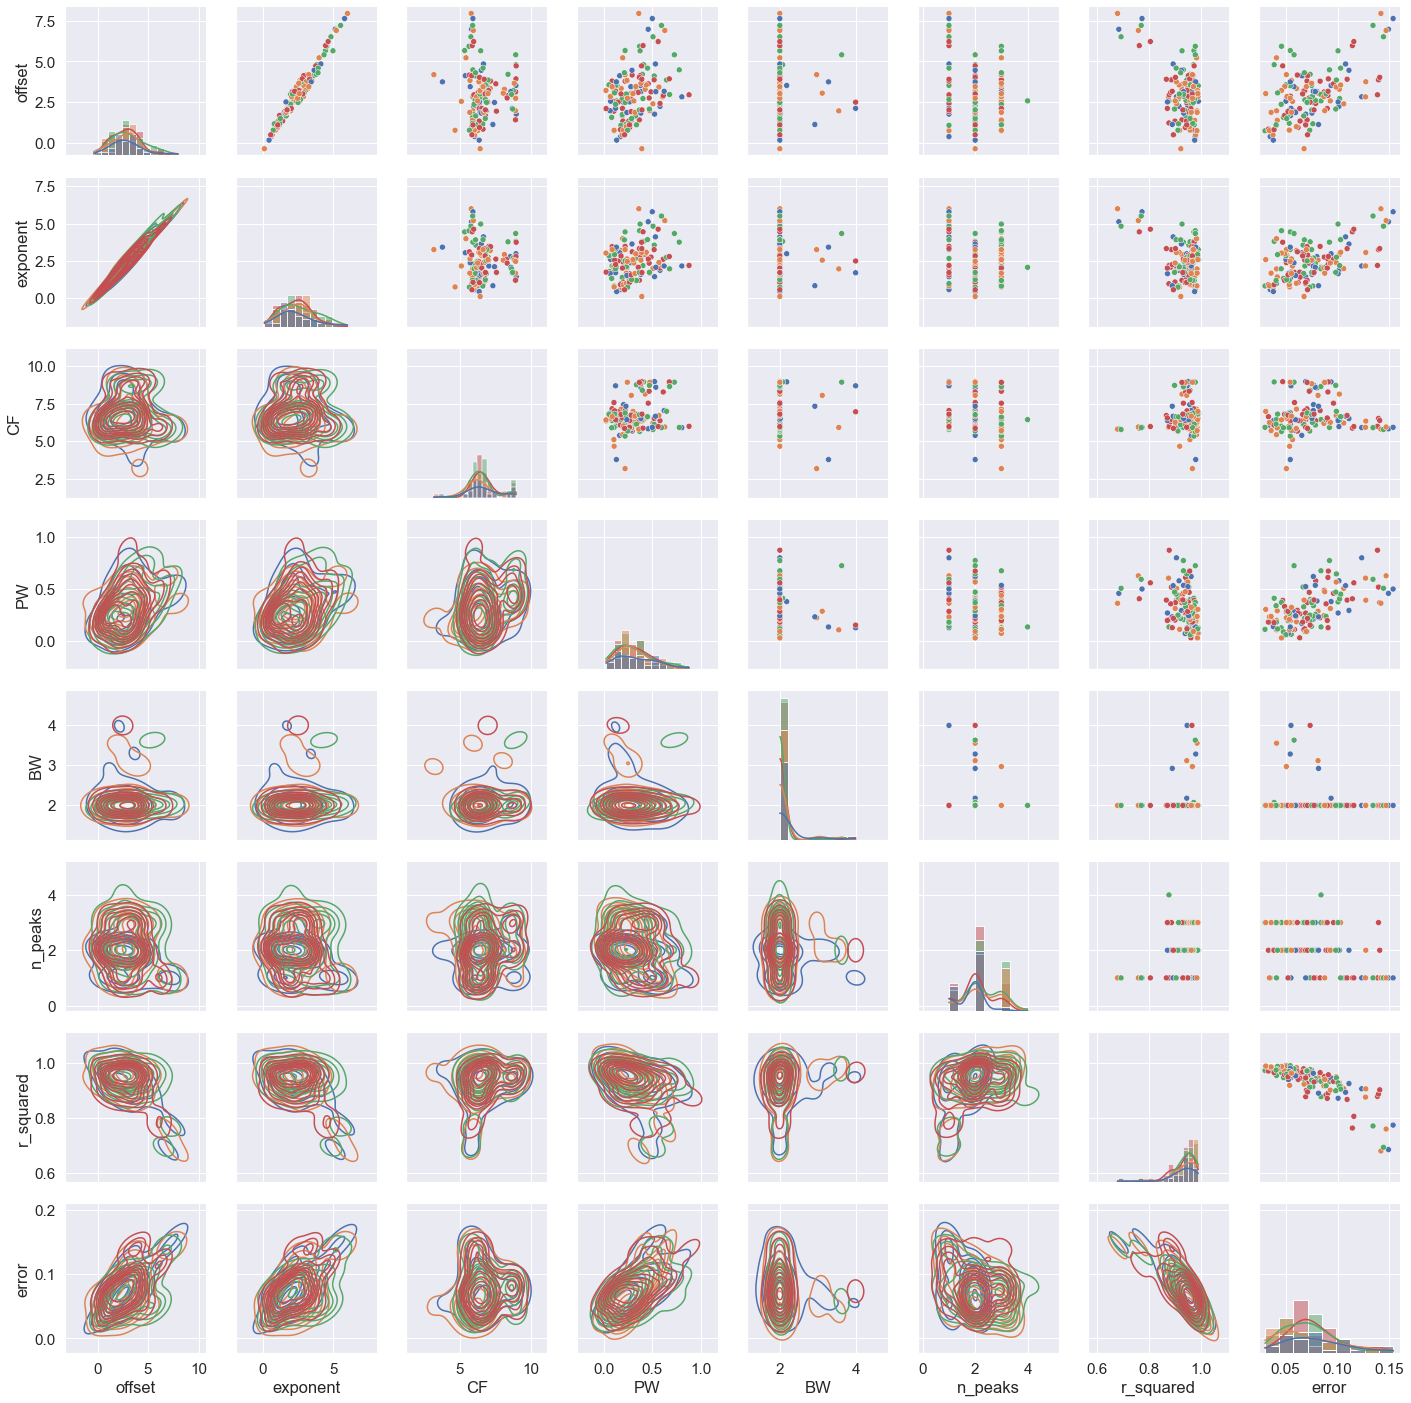

Done in 46.028s


In [55]:
tic = time.time()

g = sns.PairGrid(df_num)
g.map_upper(sns.scatterplot, hue=df['target'])
g.map_lower(sns.kdeplot, hue=df['target'], cmap = "Blues_d")
g.map_diag(sns.histplot, hue=df['target'], kde=True)
plt.show()

toc = time.time()
print(f"Done in {toc - tic:.3f}s")

## 4. Correlation matrix

,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
offset,1.00,0.43,0.98,-0.02,0.38,0.01,-0.14,-0.51,0.56
knee,0.43,1.00,0.40,-0.11,0.10,-0.03,-0.22,-0.54,0.35
exponent,0.98,0.40,1.00,-0.01,0.31,0.03,-0.13,-0.43,0.51
CF,-0.02,-0.11,-0.01,1.00,0.26,0.06,0.02,0.16,0.02
PW,0.38,0.10,0.31,0.26,1.00,-0.09,-0.24,-0.39,0.61
BW,0.01,-0.03,0.03,0.06,-0.09,1.00,-0.06,0.11,-0.11
n_peaks,-0.14,-0.22,-0.13,0.02,-0.24,-0.06,1.00,0.35,-0.33
r_squared,-0.51,-0.54,-0.43,0.16,-0.39,0.11,0.35,1.00,-0.80
error,0.56,0.35,0.51,0.02,0.61,-0.11,-0.33,-0.80,1.00


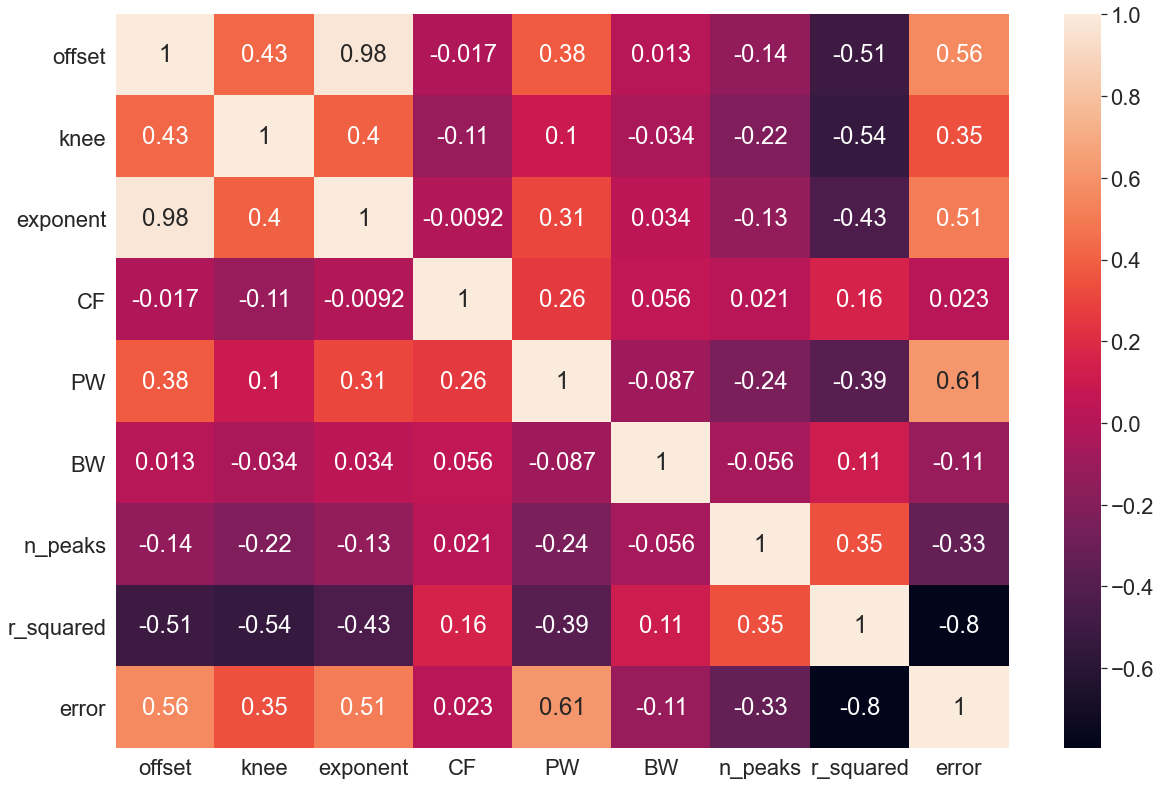

In [56]:
display(df.corr().round(2))

sns.set(font_scale = 2)
fig, heat = plt.subplots(figsize=(20,13.5))
heat = sns.heatmap(df.corr(), annot=True)
plt.show()

# IV. Classification
## Assign variables

In [57]:
# Number of observations
n_obs = len(df)

# Assign target and serie
y = df['target'].to_numpy().ravel()

# Select features
X = df.drop(columns=['subject', 'day', 'target']).to_numpy()

# Initialize dataframe
performance = pd.DataFrame([], index = [], columns = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table'])

## 1. Logistic regression

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature: 0, Score: 1.99891
Feature: 1, Score: 3.59157
Feature: 2, Score: -2.43556
Feature: 3, Score: 0.18097
Feature: 4, Score: -0.63725
Feature: 5, Score: 3.04179
Feature: 6, Score: -0.56420
Feature: 7, Score: 0.75203
Feature: 8, Score: 1.11260


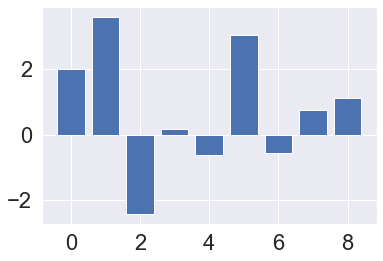

              precision    recall  f1-score   support

          50       0.40      0.22      0.29         9
          55       0.17      0.12      0.14         8
          60       0.00      0.00      0.00         5
          65       0.38      0.50      0.43         6

    accuracy                           0.21        28
   macro avg       0.24      0.21      0.21        28
weighted avg       0.26      0.21      0.22        28

Feature: 0, Score: 2.66957
Feature: 1, Score: 4.61698
Feature: 2, Score: -2.98918
Feature: 3, Score: 0.10475
Feature: 4, Score: -0.24233
Feature: 5, Score: 0.21089
Feature: 6, Score: -0.60987
Feature: 7, Score: 1.11288
Feature: 8, Score: 0.71784


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


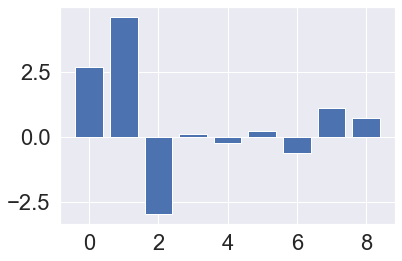

              precision    recall  f1-score   support

          50       0.00      0.00      0.00         3
          55       0.29      0.40      0.33         5
          60       0.25      0.25      0.25         8
          65       0.50      0.33      0.40        12

    accuracy                           0.29        28
   macro avg       0.26      0.25      0.25        28
weighted avg       0.34      0.29      0.30        28

Feature: 0, Score: 3.50872
Feature: 1, Score: 2.03144
Feature: 2, Score: -3.54287
Feature: 3, Score: 0.16216
Feature: 4, Score: -0.37503
Feature: 5, Score: 0.27186
Feature: 6, Score: -0.72197
Feature: 7, Score: 0.21147
Feature: 8, Score: 0.15105


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


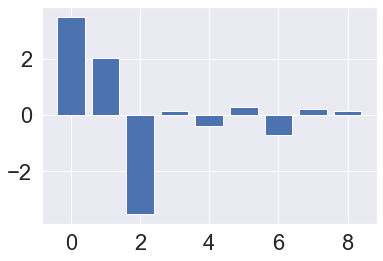

              precision    recall  f1-score   support

          50       0.00      0.00      0.00         1
          55       0.14      0.14      0.14         7
          60       0.25      0.22      0.24         9
          65       0.38      0.27      0.32        11

    accuracy                           0.21        28
   macro avg       0.19      0.16      0.17        28
weighted avg       0.26      0.21      0.24        28

Feature: 0, Score: 2.77521
Feature: 1, Score: 1.86407
Feature: 2, Score: -3.10415
Feature: 3, Score: -0.04384
Feature: 4, Score: -0.36026
Feature: 5, Score: 0.83243
Feature: 6, Score: -0.45769
Feature: 7, Score: 0.86491
Feature: 8, Score: 0.69306


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


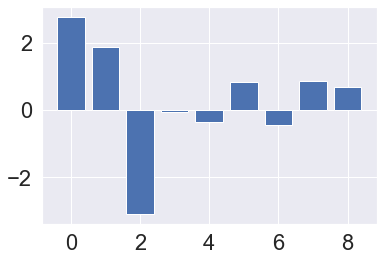

              precision    recall  f1-score   support

          50       0.00      0.00      0.00         2
          55       0.14      0.20      0.17         5
          60       0.38      0.27      0.32        11
          65       0.38      0.30      0.33        10

    accuracy                           0.25        28
   macro avg       0.22      0.19      0.20        28
weighted avg       0.31      0.25      0.27        28

Feature: 0, Score: 3.33572
Feature: 1, Score: 2.26169
Feature: 2, Score: -3.47198
Feature: 3, Score: 0.26570
Feature: 4, Score: -0.49357
Feature: 5, Score: 0.13781
Feature: 6, Score: -0.70198
Feature: 7, Score: 0.76564
Feature: 8, Score: 0.98179


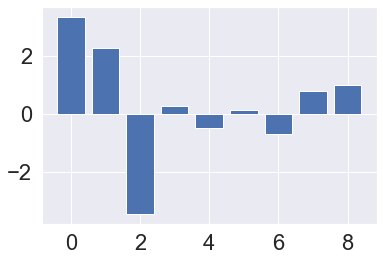

              precision    recall  f1-score   support

          50       0.00      0.00      0.00         5
          55       0.14      0.25      0.18         4
          60       0.50      0.44      0.47         9
          65       0.50      0.40      0.44        10

    accuracy                           0.32        28
   macro avg       0.29      0.27      0.27        28
weighted avg       0.36      0.32      0.34        28



In [58]:
# Split in K folds and standardize
K = 5
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Initialize model
    LR = LogisticRegression(penalty='none', random_state=13)

    # Fit model 
    LR.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = LR.predict(X_test_scaled)
    
    # Summarize feature importance
    importance = LR.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(classification_report(y_pred, y_test))

    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
    
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'log', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True) 

In [59]:
# Variance inflation factors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pd.DataFrame([variance_inflation_factor(X_scaled, i) for i in range(9)], 
             columns=['VIF'], \
             index = ['offset', 'knee', 'exponent', 'center of frequency', 'power', 'bandwidth', \
                      'n peaks', 'R2', 'MAE']).round(1)

,VIF
offset,35.1
knee,1.6
exponent,32.0
center of frequency,1.2
power,2.1
bandwidth,1.0
n peaks,1.2
R2,4.5
MAE,4.5


## 2. Ridge classifier

Feature: 0, Score: -0.00172
Feature: 1, Score: 0.00102
Feature: 2, Score: -0.00333
Feature: 3, Score: 0.00171
Feature: 4, Score: 0.00076
Feature: 5, Score: 0.00785
Feature: 6, Score: -0.01395
Feature: 7, Score: -0.00609
Feature: 8, Score: 0.00925


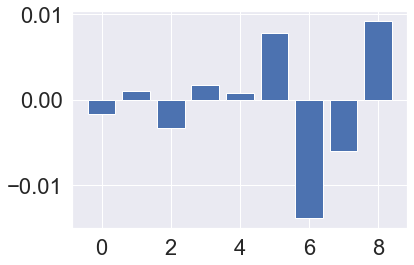

Alpha: 1077.2173450159432
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         1
          60       0.22      0.18      0.20        11
          65       0.50      0.25      0.33        16

    accuracy                           0.21        28
   macro avg       0.18      0.11      0.13        28
weighted avg       0.37      0.21      0.27        28

Feature: 0, Score: 0.00047
Feature: 1, Score: 0.01471
Feature: 2, Score: -0.04875
Feature: 3, Score: 0.02817
Feature: 4, Score: 0.03813
Feature: 5, Score: 0.04928
Feature: 6, Score: -0.11234
Feature: 7, Score: 0.03215
Feature: 8, Score: 0.02574


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


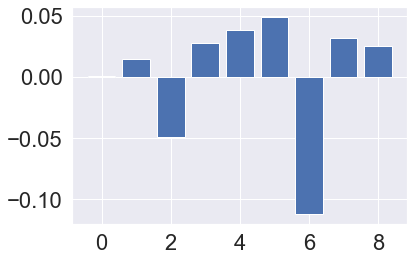

Alpha: 50.0
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         1
          60       0.38      0.27      0.32        11
          65       0.50      0.25      0.33        16

    accuracy                           0.25        28
   macro avg       0.22      0.13      0.16        28
weighted avg       0.43      0.25      0.31        28

Feature: 0, Score: 1.08029
Feature: 1, Score: -0.04572
Feature: 2, Score: -1.08719
Feature: 3, Score: 0.05067
Feature: 4, Score: -0.10653
Feature: 5, Score: 0.10102
Feature: 6, Score: -0.19422
Feature: 7, Score: 0.08079
Feature: 8, Score: 0.05002


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


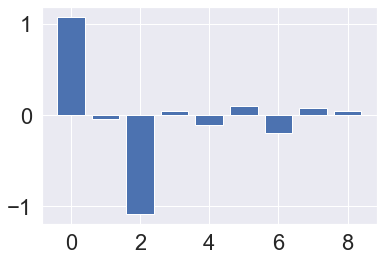

Alpha: 0.005
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         1
          55       0.14      0.12      0.13         8
          60       0.38      0.33      0.35         9
          65       0.25      0.20      0.22        10

    accuracy                           0.21        28
   macro avg       0.19      0.16      0.18        28
weighted avg       0.25      0.21      0.23        28

Feature: 0, Score: 0.00090
Feature: 1, Score: 0.09252
Feature: 2, Score: -0.05028
Feature: 3, Score: 0.00616
Feature: 4, Score: 0.00465
Feature: 5, Score: 0.09049
Feature: 6, Score: -0.07581
Feature: 7, Score: 0.00948
Feature: 8, Score: 0.02000


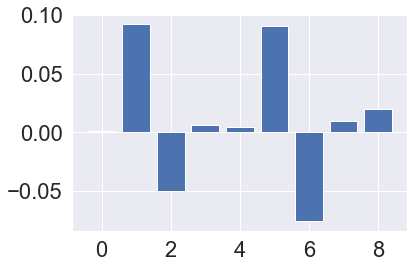

Alpha: 50.0
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         2
          55       0.14      0.33      0.20         3
          60       0.50      0.33      0.40        12
          65       0.50      0.36      0.42        11

    accuracy                           0.32        28
   macro avg       0.29      0.26      0.26        28
weighted avg       0.43      0.32      0.36        28

Feature: 0, Score: 0.02060
Feature: 1, Score: -0.02664
Feature: 2, Score: -0.03404
Feature: 3, Score: 0.03319
Feature: 4, Score: -0.00453
Feature: 5, Score: 0.05012
Feature: 6, Score: -0.11677
Feature: 7, Score: -0.02489
Feature: 8, Score: 0.07433


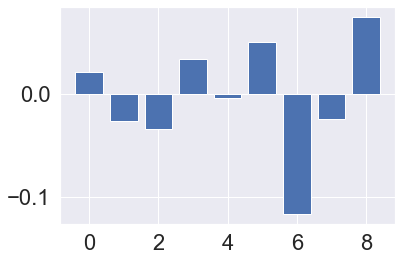

Alpha: 50.0
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         4
          55       0.00      0.00      0.00         0
          60       0.50      0.29      0.36        14
          65       0.38      0.30      0.33        10

    accuracy                           0.25        28
   macro avg       0.22      0.15      0.17        28
weighted avg       0.38      0.25      0.30        28



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize Ridge hyperparameter λ 
    hyperparameters = {"alpha": 10**np.linspace(10,-2,10)*0.5} 
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RidgeClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    RC = RidgeClassifier(alpha=Grid.best_params_['alpha'], random_state=13)

    # Fit model 
    RC.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = RC.predict(X_test_scaled)

    # Summarize feature importance
    importance = RC.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print("Alpha:",Grid.best_params_['alpha'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
         
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'ridge', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 3. K-nearest neighbors

Feature: 0, Score: -0.02857
Feature: 1, Score: -0.03571
Feature: 2, Score: -0.00000
Feature: 3, Score: -0.04286
Feature: 4, Score: -0.00714
Feature: 5, Score: -0.00714
Feature: 6, Score: -0.02143
Feature: 7, Score: 0.00714
Feature: 8, Score: 0.00000


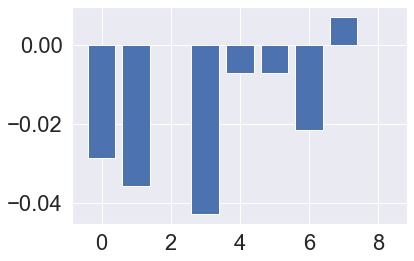

n_neighbors: 19
              precision    recall  f1-score   support

          50       0.20      0.20      0.20         5
          55       0.17      1.00      0.29         1
          60       0.22      0.29      0.25         7
          65       0.50      0.27      0.35        15

    accuracy                           0.29        28
   macro avg       0.27      0.44      0.27        28
weighted avg       0.37      0.29      0.29        28

Feature: 0, Score: 0.04286
Feature: 1, Score: -0.03571
Feature: 2, Score: 0.02143
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.02143
Feature: 6, Score: 0.01429
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


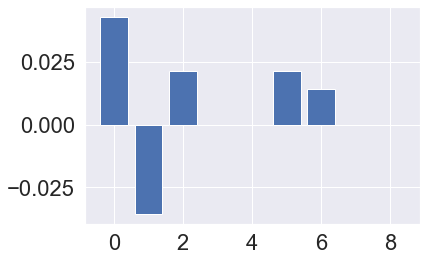

n_neighbors: 1
              precision    recall  f1-score   support

          50       0.20      0.20      0.20         5
          55       0.00      0.00      0.00         3
          60       0.12      0.14      0.13         7
          65       0.38      0.23      0.29        13

    accuracy                           0.18        28
   macro avg       0.17      0.14      0.15        28
weighted avg       0.24      0.18      0.20        28

Feature: 0, Score: -0.04286
Feature: 1, Score: -0.00714
Feature: 2, Score: -0.03571
Feature: 3, Score: -0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


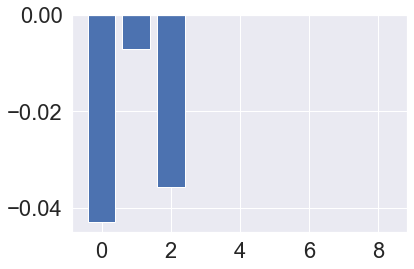

n_neighbors: 14
              precision    recall  f1-score   support

          50       0.20      0.50      0.29         2
          55       0.29      0.33      0.31         6
          60       0.62      0.36      0.45        14
          65       0.12      0.17      0.14         6

    accuracy                           0.32        28
   macro avg       0.31      0.34      0.30        28
weighted avg       0.41      0.32      0.34        28

Feature: 0, Score: 0.03571
Feature: 1, Score: 0.02143
Feature: 2, Score: 0.01429
Feature: 3, Score: 0.02143
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.05000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


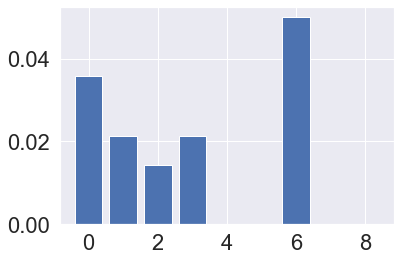

n_neighbors: 19
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         0
          55       0.29      0.40      0.33         5
          60       0.50      0.25      0.33        16
          65       0.25      0.29      0.27         7

    accuracy                           0.29        28
   macro avg       0.26      0.23      0.23        28
weighted avg       0.40      0.29      0.32        28



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Feature: 0, Score: 0.00000
Feature: 1, Score: -0.05714
Feature: 2, Score: 0.03571
Feature: 3, Score: 0.01429
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.05714
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.00714


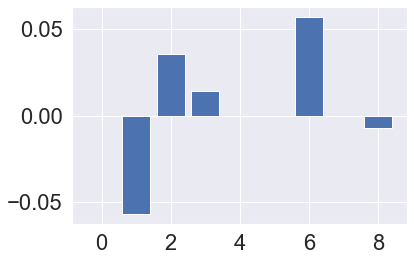

n_neighbors: 1
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         6
          55       0.14      0.11      0.12         9
          60       0.00      0.00      0.00         7
          65       0.25      0.33      0.29         6

    accuracy                           0.11        28
   macro avg       0.10      0.11      0.10        28
weighted avg       0.10      0.11      0.10        28



In [61]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize hyperparameter K
    hyperparameters = {'n_neighbors':[i for i in range(1,20)]}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(KNeighborsClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
        
    # Initialize model
    KNN = KNeighborsClassifier(n_neighbors=Grid.best_params_['n_neighbors'])
    
    # Fit model 
    KNN.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = KNN.predict(X_test_scaled)
    
    # Summarize feature importance
    results = permutation_importance(KNN, X_test, y_test, scoring='accuracy')
    importance = results.importances_mean
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print('n_neighbors:',Grid.best_params_['n_neighbors'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'KNN', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 4. Multi-layer perceptron

In [62]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Optimize hyperparameters
    hyperparameters = {'activation':['identity', 'logistic', 'tanh', 'relu'], 'solver':['lbfgs', 'sgd', 'adam']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(MLPClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    MLP = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=500, activation = Grid.best_params_['activation'], \
                        solver=Grid.best_params_['solver'], random_state=13)

    # Fit model 
    MLP.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = MLP.predict(X_test_scaled)

    # Output
    print(f"\033[1mActivation function: \033[0m{Grid.best_params_['activation']}")
    print(f"\033[1mSolver: \033[0m{Grid.best_params_['solver']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
     
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'MLP', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Activation function: logistic
Solver: adam
              precision    recall  f1-score   support

          50       0.20      0.17      0.18         6
          55       0.33      0.50      0.40         4
          60       0.22      0.33      0.27         6
          65       0.38      0.25      0.30        12

    accuracy                           0.29        28
   macro avg       0.28      0.31      0.29        28
weighted avg       0.30      0.29      0.28        28



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Activation function: logistic
Solver: adam
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         0
          60       1.00      0.29      0.44        28
          65       0.00      0.00      0.00         0

    accuracy                           0.29        28
   macro avg       0.25      0.07      0.11        28
weighted avg       1.00      0.29      0.44        28



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Activation function: identity
Solver: lbfgs
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         1
          55       0.14      0.14      0.14         7
          60       0.25      0.22      0.24         9
          65       0.38      0.27      0.32        11

    accuracy                           0.21        28
   macro avg       0.19      0.16      0.17        28
weighted avg       0.26      0.21      0.24        28

Activation function: logistic
Solver: sgd
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         0
          60       1.00      0.29      0.44        28
          65       0.00      0.00      0.00         0

    accuracy                           0.29        28
   macro avg       0.25      0.07      0.11        28
weighted avg       1.00      0.29      0.44        28



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         7
          55       0.43      0.30      0.35        10
          60       0.12      0.17      0.14         6
          65       0.25      0.40      0.31         5

    accuracy                           0.21        28
   macro avg       0.20      0.22      0.20        28
weighted avg       0.22      0.21      0.21        28



## 5. Random forest

Feature: 0, Score: 0.12212
Feature: 1, Score: 0.11807
Feature: 2, Score: 0.13337
Feature: 3, Score: 0.13996
Feature: 4, Score: 0.12610
Feature: 5, Score: 0.02060
Feature: 6, Score: 0.04291
Feature: 7, Score: 0.14820
Feature: 8, Score: 0.14867


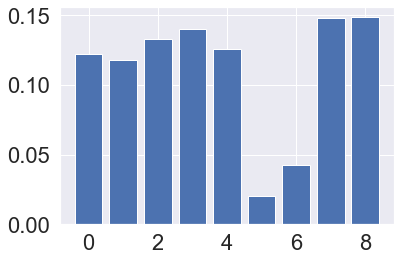

Number of trees: 2000
Maximum depth: 32
Maximum features per node split: sqrt
              precision    recall  f1-score   support

          50       0.20      0.17      0.18         6
          55       0.17      0.14      0.15         7
          60       0.00      0.00      0.00         3
          65       0.50      0.33      0.40        12

    accuracy                           0.21        28
   macro avg       0.22      0.16      0.18        28
weighted avg       0.30      0.21      0.25        28

Feature: 0, Score: 0.12320
Feature: 1, Score: 0.11778
Feature: 2, Score: 0.12794
Feature: 3, Score: 0.14197
Feature: 4, Score: 0.12180
Feature: 5, Score: 0.01812
Feature: 6, Score: 0.04684
Feature: 7, Score: 0.15893
Feature: 8, Score: 0.14343


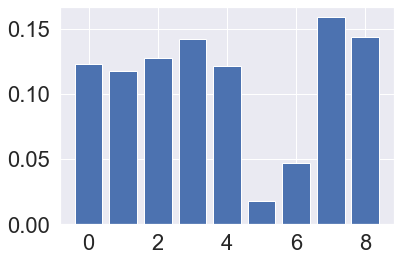

Number of trees: 200
Maximum depth: 32
Maximum features per node split: auto
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         6
          55       0.00      0.00      0.00         4
          60       0.12      0.11      0.12         9
          65       0.12      0.11      0.12         9

    accuracy                           0.07        28
   macro avg       0.06      0.06      0.06        28
weighted avg       0.08      0.07      0.08        28

Feature: 0, Score: 0.12692
Feature: 1, Score: 0.12174
Feature: 2, Score: 0.12767
Feature: 3, Score: 0.13438
Feature: 4, Score: 0.13149
Feature: 5, Score: 0.01784
Feature: 6, Score: 0.03280
Feature: 7, Score: 0.14038
Feature: 8, Score: 0.16678


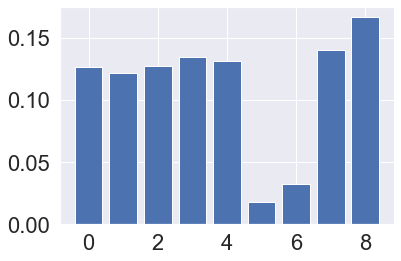

Number of trees: 200
Maximum depth: 10
Maximum features per node split: auto
              precision    recall  f1-score   support

          50       0.20      0.25      0.22         4
          55       0.14      0.20      0.17         5
          60       0.25      0.22      0.24         9
          65       0.38      0.30      0.33        10

    accuracy                           0.25        28
   macro avg       0.24      0.24      0.24        28
weighted avg       0.27      0.25      0.26        28

Feature: 0, Score: 0.12118
Feature: 1, Score: 0.11695
Feature: 2, Score: 0.11815
Feature: 3, Score: 0.15747
Feature: 4, Score: 0.12836
Feature: 5, Score: 0.02871
Feature: 6, Score: 0.03560
Feature: 7, Score: 0.14594
Feature: 8, Score: 0.14765


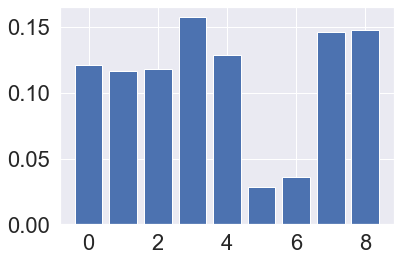

Number of trees: 200
Maximum depth: 55
Maximum features per node split: sqrt
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         1
          55       0.29      0.50      0.36         4
          60       0.75      0.50      0.60        12
          65       0.38      0.27      0.32        11

    accuracy                           0.39        28
   macro avg       0.35      0.32      0.32        28
weighted avg       0.51      0.39      0.43        28

Feature: 0, Score: 0.10755
Feature: 1, Score: 0.12518
Feature: 2, Score: 0.12681
Feature: 3, Score: 0.14073
Feature: 4, Score: 0.14140
Feature: 5, Score: 0.01419
Feature: 6, Score: 0.04559
Feature: 7, Score: 0.14704
Feature: 8, Score: 0.15151


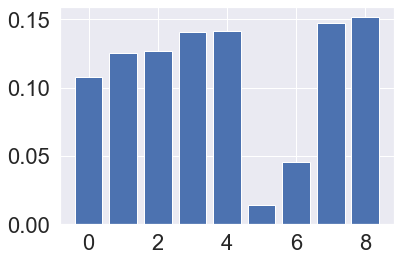

Number of trees: 200
Maximum depth: 77
Maximum features per node split: auto
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         3
          55       0.29      0.18      0.22        11
          60       0.12      0.11      0.12         9
          65       0.25      0.40      0.31         5

    accuracy                           0.18        28
   macro avg       0.17      0.17      0.16        28
weighted avg       0.20      0.18      0.18        28

Done in 1365.7435698509216 seconds


In [63]:
tic = time.time()

# Split in K folds
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    # Optimize hyperparameters
    hyperparameters = {"n_estimators": [200, 1000, 2000], \
                       "max_depth": [int(x) for x in np.linspace(10, 100, num = 5)],\
                       "max_features": ['auto', 'sqrt']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RandomForestClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train, y_train)
    
    # Initiating a RF classifier
    RFC = RandomForestClassifier(n_estimators = Grid.best_params_['n_estimators'], \
                                max_depth = Grid.best_params_['max_depth'], \
                                max_features = Grid.best_params_['max_features'], random_state = 13)  

    # Fit model
    RFC.fit(X_train, y_train)
  
    # performing predictions on the test dataset
    y_pred = RFC.predict(X_test)
    
    # Summarize feature importance
    importance = RFC.feature_importances_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(f"\033[1mNumber of trees: \033[0m{Grid.best_params_['n_estimators']}")
    print(f"\033[1mMaximum depth: \033[0m{Grid.best_params_['max_depth']}")
    print(f"\033[1mMaximum features per node split: \033[0m{Grid.best_params_['max_features']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'RF',  n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)    

print(f'Done in {time.time()-tic} seconds')

# Same for 3 channels
# I. Preparation

In [64]:
# Occipital channels
channels = (23,24,25) 
n_channels = 3

# II. Fourier transform and FOOOF

In [65]:
## Read EEG, calculate PSD (Welch), fit FOOOF

tic = time.time()
for subject in subjects: 
    for day in days:
        # Initialize per target, average over trials and channels
        powers_50 = np.empty((0, int(nperseg//2)+1), float)
        powers_55 = np.empty((0, int(nperseg//2)+1), float)
        powers_60 = np.empty((0, int(nperseg//2)+1), float)
        powers_65 = np.empty((0, int(nperseg//2)+1), float)
        powers_210 = np.empty((0, int(nperseg//2)+1), float)
        powers_215 = np.empty((0, int(nperseg//2)+1), float)
        powers_220 = np.empty((0, int(nperseg//2)+1), float)
        powers_225 = np.empty((0, int(nperseg//2)+1), float)
        powers_400 = np.empty((0, int(nperseg//2)+1), float)
        powers_405 = np.empty((0, int(nperseg//2)+1), float)
        powers_410 = np.empty((0, int(nperseg//2)+1), float)
        powers_415 = np.empty((0, int(nperseg//2)+1), float)

        # Change working directory
        original = os.getcwd()
        os.chdir("C:/Users/ThinkPad/Desktop/Thesis/Data/"+subject+day)

        # Giving directory name
        folderdir = 'C:/Users/ThinkPad/Desktop/Thesis/Data/'+subject+day

        # Giving file extensions
        ext = ('.mat')

        # Iterating over directory
        for path, dirc, files in os.walk(folderdir):
            for file in files:
                if file.endswith(ext) and file.startswith('cnt'):
                    print(subject, day, file)

                    # LOW, MID, or HIGH
                    level = file[4:-7]

                    # Session 1, or session 2
                    session = file[-6]

                    # Read data
                    data = read_matlab(file)['cnt']['x']

                    # Read timestamps 
                    timestamps = (read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['time'])[0]

                    # Read stimuli order
                    order_stimuli = read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['event']['desc']

                    for trial, timestamp in enumerate(timestamps):   
                        if trial%2 == False:
                            start = int(timestamp)
                        else:
                            stop = int(timestamp)

                            for channel in channels:
#                                 # Apply bandpass filter
#                                 data[:,channel] = filter_signal(data[:,channel], fs, 'bandpass', f_range=fr)

                                # Splice data according to timestamps
                                sig = data[:,channel][start:stop]
                                times = create_times(len(sig)/fs, fs)

#                                 # Plot EEG 
#                                 fig, ax = plt.subplots(figsize=[15, 5])
#                                 plot_time_series(times, sig, xlim=[0,len(sig)/fs], ax=ax)
#                                 plt.show()                                

                                # Welch FFT: calculate mean of spectrogram
                                freq, power = signal.welch(sig, fs, window='hann', average='mean', nperseg=nperseg,\
                                                          noverlap=450, detrend='constant')

                                                                # Append power to previous powers
                                if level=='LOW':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_50 = np.append(powers_50, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_55 = np.append(powers_55, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_60 = np.append(powers_60, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_65 = np.append(powers_65, power.reshape(1, len(freq)), axis=0)
                                elif level=='MID':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_210 = np.append(powers_210, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_215 = np.append(powers_215, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_220 = np.append(powers_220, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_225 = np.append(powers_225, power.reshape(1, len(freq)), axis=0)
                                elif level=='HIGH':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_400 = np.append(powers_400, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_405 = np.append(powers_405, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_410 = np.append(powers_410, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_415 = np.append(powers_415, power.reshape(1, len(freq)), axis=0)
                                        
        # Fit FOOOF model per target
        for (powers, target) in zip((powers_50, powers_55, powers_60, powers_65), \
                                    (50, 55, 60, 65)):
            # FOOOF object: initialize, fit and print results
            fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
            fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
            fm.print_results()
#             fig, ax = plt.subplots(figsize=[15, 5])
#             fm.plot(plot_peaks='line-shade', ax=ax)
#             plt.show()

            # Save metadata, FOOOF parameters and results
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=True)[0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass

# Typecast dataframe
df[['subject', 'day', 'target']] = df[['subject', 'day', 'target']].astype('category')
df['n_peaks'] = df['n_peaks'].astype('int32')
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']] = \
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']].astype('float32')

# Change working directory back
os.chdir(original)

print(f'Done in {time.time()-tic} seconds')

S1 /Day1 cnt_HIGH(1).mat
S1 /Day1 cnt_HIGH(2).mat
S1 /Day1 cnt_LOW(1).mat
S1 /Day1 cnt_LOW(2).mat
S1 /Day1 cnt_MID(1).mat
S1 /Day1 cnt_MID(2).mat
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    3.7756, 1955.7955, 3.1439                                     
                                                              

C:\Users\ThinkPad\anaconda3\lib\site-packages\fooof\core\funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


S27 /Day1 cnt_HIGH(2).mat
S27 /Day1 cnt_LOW(1).mat
S27 /Day1 cnt_LOW(2).mat
S27 /Day1 cnt_MID(1).mat
S27 /Day1 cnt_MID(2).mat
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     1.6968, -1.2672, 1.4712                                      
                                                                                  

# IV. Classification
## Assign variables

In [66]:
# Number of observations
n_obs = len(df)

# Assign target and serie
y = df['target'].to_numpy().ravel()

# Select features
X = df.drop(columns=['subject', 'day', 'target']).to_numpy()

## 1. Logistic regression

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature: 0, Score: 2.50515
Feature: 1, Score: 2.17484
Feature: 2, Score: -2.53164
Feature: 3, Score: -0.09854
Feature: 4, Score: -0.23763
Feature: 5, Score: 0.20479
Feature: 6, Score: -0.37573
Feature: 7, Score: 0.41346
Feature: 8, Score: 0.53455


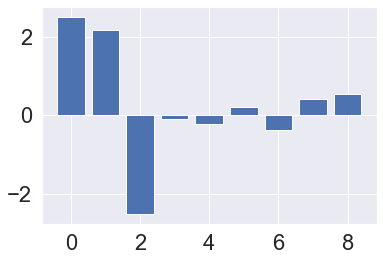

              precision    recall  f1-score   support

          50       0.20      0.50      0.29         4
          55       0.14      0.33      0.20         6
          60       0.47      0.36      0.41        22
          65       0.61      0.41      0.49        27

    accuracy                           0.39        59
   macro avg       0.36      0.40      0.35        59
weighted avg       0.48      0.39      0.42        59

Feature: 0, Score: 3.23411
Feature: 1, Score: 1.64073
Feature: 2, Score: -3.54982
Feature: 3, Score: 0.03508
Feature: 4, Score: -0.19296
Feature: 5, Score: 0.14448
Feature: 6, Score: -0.29463
Feature: 7, Score: 0.55906
Feature: 8, Score: 0.60680


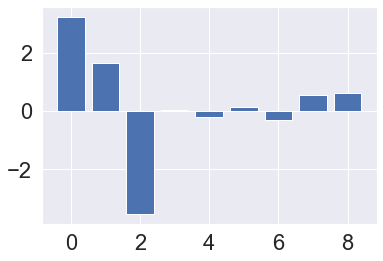

              precision    recall  f1-score   support

          50       0.30      0.33      0.32         9
          55       0.33      0.31      0.32        16
          60       0.41      0.54      0.47        13
          65       0.53      0.43      0.47        21

    accuracy                           0.41        59
   macro avg       0.39      0.40      0.39        59
weighted avg       0.42      0.41      0.41        59

Feature: 0, Score: 3.13108
Feature: 1, Score: 44.24424
Feature: 2, Score: -3.19882
Feature: 3, Score: 0.02920
Feature: 4, Score: -0.37101
Feature: 5, Score: 0.20976
Feature: 6, Score: -0.43425
Feature: 7, Score: 0.43735
Feature: 8, Score: 0.58416


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


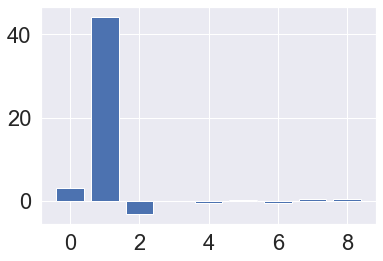

              precision    recall  f1-score   support

          50       0.00      0.00      0.00         3
          55       0.07      0.20      0.10         5
          60       0.29      0.38      0.33        13
          65       0.82      0.37      0.51        38

    accuracy                           0.34        59
   macro avg       0.30      0.24      0.24        59
weighted avg       0.60      0.34      0.41        59

Feature: 0, Score: 3.43398
Feature: 1, Score: 95.05578
Feature: 2, Score: -3.69848
Feature: 3, Score: -0.03254
Feature: 4, Score: -0.42010
Feature: 5, Score: 0.19407
Feature: 6, Score: -0.30838
Feature: 7, Score: 0.68112
Feature: 8, Score: 0.65376


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


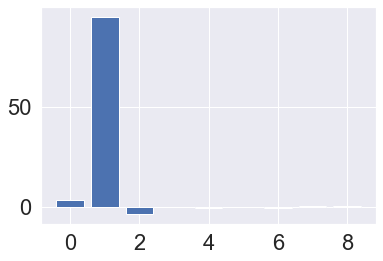

              precision    recall  f1-score   support

          50       0.10      0.20      0.13         5
          55       0.21      0.27      0.24        11
          60       0.35      0.29      0.32        21
          65       0.59      0.48      0.53        21

    accuracy                           0.34        58
   macro avg       0.31      0.31      0.30        58
weighted avg       0.39      0.34      0.36        58

Feature: 0, Score: 2.53378
Feature: 1, Score: -2.80325
Feature: 2, Score: -2.60982
Feature: 3, Score: 0.02903
Feature: 4, Score: -0.31232
Feature: 5, Score: 0.17732
Feature: 6, Score: -0.41668
Feature: 7, Score: 0.43458
Feature: 8, Score: 0.68821


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


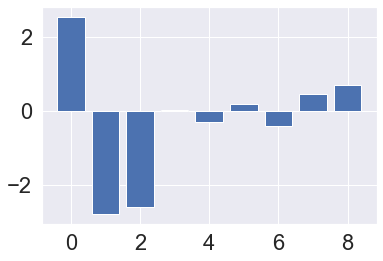

              precision    recall  f1-score   support

          50       0.00      0.00      0.00         3
          55       0.00      0.00      0.00         4
          60       0.50      0.31      0.38        26
          65       0.47      0.32      0.38        25

    accuracy                           0.28        58
   macro avg       0.24      0.16      0.19        58
weighted avg       0.43      0.28      0.33        58



In [67]:
# Split in K folds and standardize
K = 5
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Initialize model
    LR = LogisticRegression(penalty='none', random_state=13)

    # Fit model 
    LR.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = LR.predict(X_test_scaled)
    
    # Summarize feature importance
    importance = LR.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(classification_report(y_pred, y_test))

    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
    
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'log', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True) 

In [68]:
# Variance inflation factors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pd.DataFrame([variance_inflation_factor(X_scaled, i) for i in range(9)], 
             columns=['VIF'], \
             index = ['offset', 'knee', 'exponent', 'center of frequency', 'power', 'bandwidth', \
                      'n peaks', 'R2', 'MAE']).round(1)

,VIF
offset,43.7
knee,1.1
exponent,40.5
center of frequency,1.2
power,1.9
bandwidth,1.1
n peaks,1.2
R2,3.6
MAE,4.1


## 2. Ridge classifier

Feature: 0, Score: -0.00264
Feature: 1, Score: -0.00432
Feature: 2, Score: -0.00617
Feature: 3, Score: -0.00726
Feature: 4, Score: 0.00416
Feature: 5, Score: 0.00901
Feature: 6, Score: -0.01824
Feature: 7, Score: -0.00254
Feature: 8, Score: 0.01042


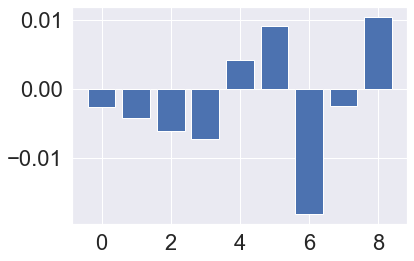

Alpha: 1077.2173450159432
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         0
          60       0.53      0.36      0.43        25
          65       0.67      0.35      0.46        34

    accuracy                           0.36        59
   macro avg       0.30      0.18      0.22        59
weighted avg       0.61      0.36      0.45        59

Feature: 0, Score: -0.00300
Feature: 1, Score: 0.00134
Feature: 2, Score: -0.00914
Feature: 3, Score: 0.00091
Feature: 4, Score: 0.01071
Feature: 5, Score: 0.00496
Feature: 6, Score: -0.01588
Feature: 7, Score: -0.00827
Feature: 8, Score: 0.01243


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


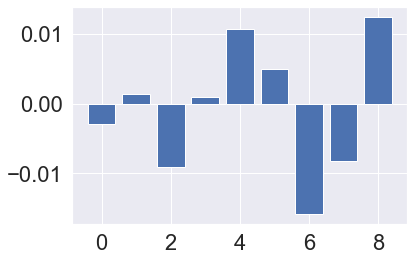

Alpha: 1077.2173450159432
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         1
          60       0.53      0.39      0.45        23
          65       0.76      0.37      0.50        35

    accuracy                           0.37        59
   macro avg       0.32      0.19      0.24        59
weighted avg       0.66      0.37      0.47        59



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Feature: 0, Score: 0.04620
Feature: 1, Score: -0.02859
Feature: 2, Score: -0.05064
Feature: 3, Score: -0.00354
Feature: 4, Score: -0.02736
Feature: 5, Score: 0.05207
Feature: 6, Score: -0.09491
Feature: 7, Score: -0.03238
Feature: 8, Score: 0.05373


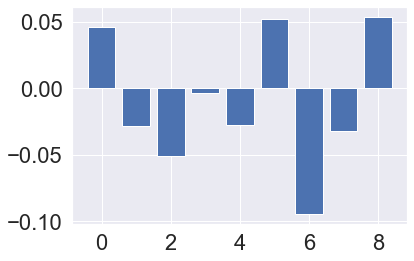

Alpha: 50.0
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         4
          55       0.07      0.25      0.11         4
          60       0.35      0.50      0.41        12
          65       0.82      0.36      0.50        39

    accuracy                           0.36        59
   macro avg       0.31      0.28      0.25        59
weighted avg       0.62      0.36      0.42        59

Feature: 0, Score: 1.00747
Feature: 1, Score: -0.02726
Feature: 2, Score: -1.05383
Feature: 3, Score: -0.00690
Feature: 4, Score: -0.12223
Feature: 5, Score: 0.07239
Feature: 6, Score: -0.08086
Feature: 7, Score: 0.17022
Feature: 8, Score: 0.17447


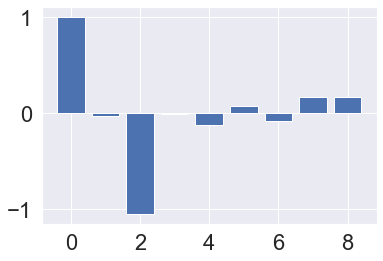

Alpha: 0.10772173450159434
              precision    recall  f1-score   support

          50       0.10      0.25      0.14         4
          55       0.14      0.50      0.22         4
          60       0.47      0.31      0.37        26
          65       0.53      0.38      0.44        24

    accuracy                           0.34        58
   macro avg       0.31      0.36      0.29        58
weighted avg       0.45      0.34      0.37        58

Feature: 0, Score: -0.00169
Feature: 1, Score: -0.00400
Feature: 2, Score: -0.00594
Feature: 3, Score: 0.00151
Feature: 4, Score: 0.00477
Feature: 5, Score: 0.00838
Feature: 6, Score: -0.01884
Feature: 7, Score: -0.00716
Feature: 8, Score: 0.01560


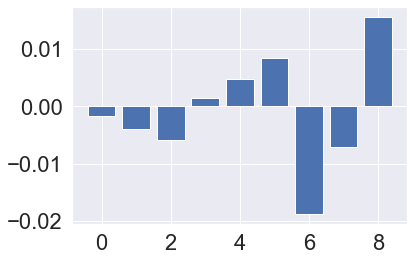

Alpha: 1077.2173450159432
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         0
          60       0.50      0.40      0.44        20
          65       0.82      0.37      0.51        38

    accuracy                           0.38        58
   macro avg       0.33      0.19      0.24        58
weighted avg       0.71      0.38      0.49        58



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize Ridge hyperparameter λ 
    hyperparameters = {"alpha": 10**np.linspace(10,-2,10)*0.5} 
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RidgeClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    RC = RidgeClassifier(alpha=Grid.best_params_['alpha'], random_state=13)

    # Fit model 
    RC.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = RC.predict(X_test_scaled)

    # Summarize feature importance
    importance = RC.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print("Alpha:",Grid.best_params_['alpha'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
         
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'ridge', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 3. K-nearest neighbors

Feature: 0, Score: 0.02034
Feature: 1, Score: 0.02373
Feature: 2, Score: 0.02034
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00678
Feature: 6, Score: 0.00678
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


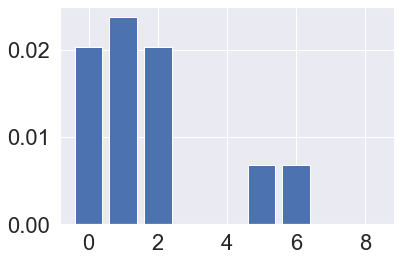

n_neighbors: 1
              precision    recall  f1-score   support

          50       0.40      0.25      0.31        16
          55       0.36      0.45      0.40        11
          60       0.41      0.50      0.45        14
          65       0.56      0.56      0.56        18

    accuracy                           0.44        59
   macro avg       0.43      0.44      0.43        59
weighted avg       0.44      0.44      0.43        59

Feature: 0, Score: 0.05763
Feature: 1, Score: -0.03729
Feature: 2, Score: 0.04746
Feature: 3, Score: 0.03729
Feature: 4, Score: 0.00678
Feature: 5, Score: 0.02373
Feature: 6, Score: 0.01017
Feature: 7, Score: 0.01356
Feature: 8, Score: 0.01356


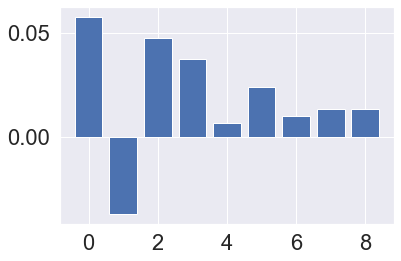

n_neighbors: 1
              precision    recall  f1-score   support

          50       0.30      0.50      0.37         6
          55       0.40      0.32      0.35        19
          60       0.47      0.42      0.44        19
          65       0.59      0.67      0.62        15

    accuracy                           0.46        59
   macro avg       0.44      0.48      0.45        59
weighted avg       0.46      0.46      0.45        59

Feature: 0, Score: -0.02034
Feature: 1, Score: -0.01356
Feature: 2, Score: -0.01356
Feature: 3, Score: 0.01695
Feature: 4, Score: 0.01356
Feature: 5, Score: -0.00339
Feature: 6, Score: 0.00339
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00339


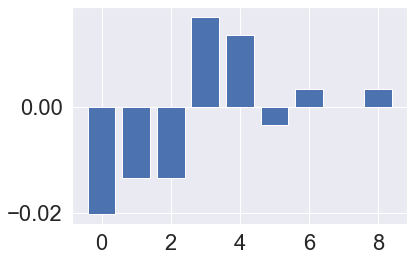

n_neighbors: 1
              precision    recall  f1-score   support

          50       0.40      0.27      0.32        15
          55       0.27      0.36      0.31        11
          60       0.41      0.37      0.39        19
          65       0.59      0.71      0.65        14

    accuracy                           0.42        59
   macro avg       0.42      0.43      0.42        59
weighted avg       0.42      0.42      0.42        59

Feature: 0, Score: -0.01379
Feature: 1, Score: 0.01724
Feature: 2, Score: -0.01034
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.01379
Feature: 5, Score: -0.00345
Feature: 6, Score: 0.03103
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


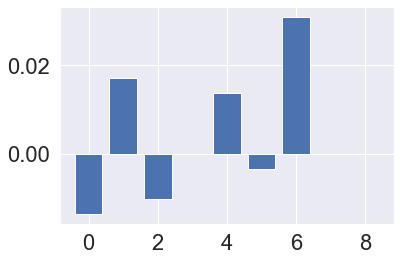

n_neighbors: 1
              precision    recall  f1-score   support

          50       0.60      0.43      0.50        14
          55       0.29      0.36      0.32        11
          60       0.35      0.43      0.39        14
          65       0.65      0.58      0.61        19

    accuracy                           0.47        58
   macro avg       0.47      0.45      0.45        58
weighted avg       0.50      0.47      0.48        58

Feature: 0, Score: -0.01379
Feature: 1, Score: 0.02414
Feature: 2, Score: -0.00000
Feature: 3, Score: -0.00690
Feature: 4, Score: -0.01034
Feature: 5, Score: -0.00345
Feature: 6, Score: -0.01724
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


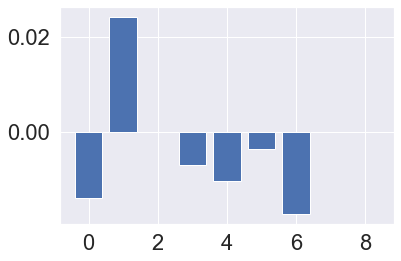

n_neighbors: 1
              precision    recall  f1-score   support

          50       0.27      0.38      0.32         8
          55       0.43      0.33      0.38        18
          60       0.50      0.42      0.46        19
          65       0.41      0.54      0.47        13

    accuracy                           0.41        58
   macro avg       0.40      0.42      0.40        58
weighted avg       0.43      0.41      0.41        58



In [70]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize hyperparameter K
    hyperparameters = {'n_neighbors':[i for i in range(1,20)]}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(KNeighborsClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
        
    # Initialize model
    KNN = KNeighborsClassifier(n_neighbors=Grid.best_params_['n_neighbors'])
    
    # Fit model 
    KNN.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = KNN.predict(X_test_scaled)
    
    # Summarize feature importance
    results = permutation_importance(KNN, X_test, y_test, scoring='accuracy')
    importance = results.importances_mean
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print('n_neighbors:',Grid.best_params_['n_neighbors'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'KNN', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 4. Multi-layer perceptron

In [71]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Optimize hyperparameters
    hyperparameters = {'activation':['identity', 'logistic', 'tanh', 'relu'], 'solver':['lbfgs', 'sgd', 'adam']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(MLPClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    MLP = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=500, activation = Grid.best_params_['activation'], \
                        solver=Grid.best_params_['solver'], random_state=13)

    # Fit model 
    MLP.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = MLP.predict(X_test_scaled)

    # Output
    print(f"\033[1mActivation function: \033[0m{Grid.best_params_['activation']}")
    print(f"\033[1mSolver: \033[0m{Grid.best_params_['solver']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
     
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'MLP', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

Activation function: relu
Solver: lbfgs
              precision    recall  f1-score   support

          50       0.30      0.25      0.27        12
          55       0.36      0.56      0.43         9
          60       0.53      0.45      0.49        20
          65       0.44      0.44      0.44        18

    accuracy                           0.42        59
   macro avg       0.41      0.42      0.41        59
weighted avg       0.43      0.42      0.42        59

Activation function: relu
Solver: lbfgs
              precision    recall  f1-score   support

          50       0.50      0.45      0.48        11
          55       0.53      0.42      0.47        19
          60       0.41      0.44      0.42        16
          65       0.47      0.62      0.53        13

    accuracy                           0.47        59
   macro avg       0.48      0.48      0.48        59
weighted avg       0.48      0.47      0.47        59



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

          50       0.20      0.25      0.22         8
          55       0.40      0.43      0.41        14
          60       0.35      0.33      0.34        18
          65       0.59      0.53      0.56        19

    accuracy                           0.41        59
   macro avg       0.39      0.38      0.38        59
weighted avg       0.42      0.41      0.41        59



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

          50       0.60      0.43      0.50        14
          55       0.29      0.44      0.35         9
          60       0.71      0.57      0.63        21
          65       0.47      0.57      0.52        14

    accuracy                           0.52        58
   macro avg       0.52      0.50      0.50        58
weighted avg       0.56      0.52      0.53        58



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

          50       0.18      0.20      0.19        10
          55       0.36      0.26      0.30        19
          60       0.31      0.36      0.33        14
          65       0.35      0.40      0.38        15

    accuracy                           0.31        58
   macro avg       0.30      0.31      0.30        58
weighted avg       0.32      0.31      0.31        58



## 5. Random forest

Feature: 0, Score: 0.10871
Feature: 1, Score: 0.11798
Feature: 2, Score: 0.10986
Feature: 3, Score: 0.17442
Feature: 4, Score: 0.12662
Feature: 5, Score: 0.02040
Feature: 6, Score: 0.04866
Feature: 7, Score: 0.14908
Feature: 8, Score: 0.14426


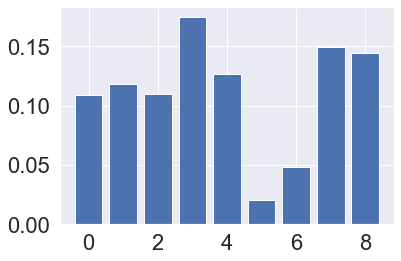

Number of trees: 200
Maximum depth: 32
Maximum features per node split: auto
              precision    recall  f1-score   support

          50       0.30      0.30      0.30        10
          55       0.43      0.60      0.50        10
          60       0.53      0.50      0.51        18
          65       0.44      0.38      0.41        21

    accuracy                           0.44        59
   macro avg       0.43      0.45      0.43        59
weighted avg       0.44      0.44      0.44        59

Feature: 0, Score: 0.11083
Feature: 1, Score: 0.11914
Feature: 2, Score: 0.12480
Feature: 3, Score: 0.17130
Feature: 4, Score: 0.13007
Feature: 5, Score: 0.01893
Feature: 6, Score: 0.04125
Feature: 7, Score: 0.12610
Feature: 8, Score: 0.15758


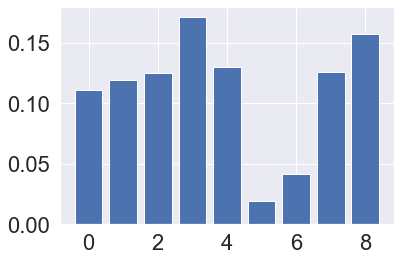

Number of trees: 200
Maximum depth: 55
Maximum features per node split: auto
              precision    recall  f1-score   support

          50       0.30      0.60      0.40         5
          55       0.33      0.42      0.37        12
          60       0.59      0.56      0.57        18
          65       0.76      0.54      0.63        24

    accuracy                           0.53        59
   macro avg       0.50      0.53      0.49        59
weighted avg       0.58      0.53      0.54        59

Feature: 0, Score: 0.11604
Feature: 1, Score: 0.12150
Feature: 2, Score: 0.12229
Feature: 3, Score: 0.16644
Feature: 4, Score: 0.12372
Feature: 5, Score: 0.01616
Feature: 6, Score: 0.04146
Feature: 7, Score: 0.13926
Feature: 8, Score: 0.15312


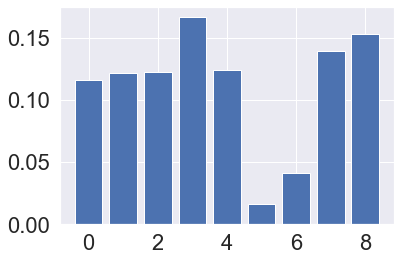

Number of trees: 2000
Maximum depth: 77
Maximum features per node split: sqrt
              precision    recall  f1-score   support

          50       0.10      0.20      0.13         5
          55       0.27      0.50      0.35         8
          60       0.53      0.64      0.58        14
          65       0.88      0.47      0.61        32

    accuracy                           0.49        59
   macro avg       0.44      0.45      0.42        59
weighted avg       0.65      0.49      0.53        59

Feature: 0, Score: 0.11647
Feature: 1, Score: 0.12709
Feature: 2, Score: 0.12488
Feature: 3, Score: 0.16095
Feature: 4, Score: 0.13089
Feature: 5, Score: 0.01910
Feature: 6, Score: 0.03774
Feature: 7, Score: 0.14929
Feature: 8, Score: 0.13359


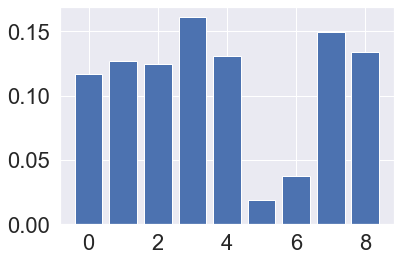

Number of trees: 200
Maximum depth: 32
Maximum features per node split: auto
              precision    recall  f1-score   support

          50       0.40      0.40      0.40        10
          55       0.36      0.31      0.33        16
          60       0.35      0.38      0.36        16
          65       0.41      0.44      0.42        16

    accuracy                           0.38        58
   macro avg       0.38      0.38      0.38        58
weighted avg       0.38      0.38      0.38        58

Feature: 0, Score: 0.10520
Feature: 1, Score: 0.11189
Feature: 2, Score: 0.10975
Feature: 3, Score: 0.18165
Feature: 4, Score: 0.12312
Feature: 5, Score: 0.02195
Feature: 6, Score: 0.04427
Feature: 7, Score: 0.15019
Feature: 8, Score: 0.15198


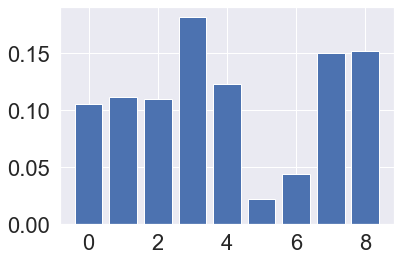

Number of trees: 200
Maximum depth: 55
Maximum features per node split: sqrt
              precision    recall  f1-score   support

          50       0.09      0.12      0.11         8
          55       0.50      0.41      0.45        17
          60       0.44      0.50      0.47        14
          65       0.53      0.47      0.50        19

    accuracy                           0.41        58
   macro avg       0.39      0.38      0.38        58
weighted avg       0.44      0.41      0.42        58

Done in 738.8828709125519 seconds


In [72]:
tic = time.time()

# Split in K folds
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    # Optimize hyperparameters
    hyperparameters = {"n_estimators": [200, 1000, 2000], \
                       "max_depth": [int(x) for x in np.linspace(10, 100, num = 5)],\
                       "max_features": ['auto', 'sqrt']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RandomForestClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train, y_train)
    
    # Initiating a RF classifier
    RFC = RandomForestClassifier(n_estimators = Grid.best_params_['n_estimators'], \
                                max_depth = Grid.best_params_['max_depth'], \
                                max_features = Grid.best_params_['max_features'], random_state = 13)  

    # Fit model
    RFC.fit(X_train, y_train)
  
    # performing predictions on the test dataset
    y_pred = RFC.predict(X_test)
    
    # Summarize feature importance
    importance = RFC.feature_importances_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(f"\033[1mNumber of trees: \033[0m{Grid.best_params_['n_estimators']}")
    print(f"\033[1mMaximum depth: \033[0m{Grid.best_params_['max_depth']}")
    print(f"\033[1mMaximum features per node split: \033[0m{Grid.best_params_['max_features']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'RF',  n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)  

print(f'Done in {time.time()-tic} seconds')

# V. Statistics

In [73]:
# Typecast dataframe
performance[['classifier', 'n_channels', 'table']] = performance[['classifier', 'n_channels', 'table']].astype('category')
performance[['accuracy', 'precision', 'recall']] = performance[['accuracy', 'precision', 'recall']].astype('float32')

# Save as csv
df.to_csv('df_table2.csv')
performance.to_csv('performance_table2.csv')

# Display
display(performance)
display(df)

,accuracy,precision,recall,classifier,n_channels,table
0,0.21,0.26,0.21,log,13,2
1,0.29,0.34,0.29,log,13,2
2,0.21,0.26,0.21,log,13,2
3,0.25,0.31,0.25,log,13,2
4,0.32,0.36,0.32,log,13,2
5,0.21,0.37,0.21,ridge,13,2
6,0.25,0.43,0.25,ridge,13,2
7,0.21,0.25,0.21,ridge,13,2
8,0.32,0.43,0.32,ridge,13,2
9,0.25,0.38,0.25,ridge,13,2


,subject,day,target,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
0,S1,/Day1,60,2.575504,110.889587,2.066221,6.448652,0.131256,2.0,4,0.875963,0.084074
1,S1,/Day2,50,2.476227,79.799011,2.106115,7.446962,0.205194,2.0,2,0.955792,0.076776
2,S1,/Day2,60,2.637844,134.310135,2.155900,6.389362,0.086946,2.0,3,0.963514,0.068488
3,S1,/Day2,65,3.130147,397.794403,2.751113,8.928272,0.485694,2.0,3,0.948914,0.087213
4,S2,/Day1,50,2.238204,25.191677,1.865300,5.989741,0.577807,2.0,2,0.914587,0.101412
...,...,...,...,...,...,...,...,...,...,...,...,...
288,S30,/Day1,65,1.714805,3.682827,1.257452,6.718073,0.260314,2.0,2,0.936445,0.052786
289,S30,/Day2,50,1.860597,7.407424,1.493562,6.497082,0.331464,2.0,3,0.898569,0.091263
290,S30,/Day2,55,1.943061,9.971169,1.550166,6.621682,0.268942,2.0,2,0.943335,0.062469
291,S30,/Day2,60,2.142327,19.028496,1.654540,6.716576,0.320796,2.0,2,0.907675,0.080437


In [74]:
# Mean
display(pd.concat([performance.groupby(['classifier', 'n_channels']).agg({'accuracy': ['mean']}),\
                   performance.groupby(['classifier', 'n_channels']).agg({'precision': ['mean']}),\
                   performance.groupby(['classifier', 'n_channels']).agg({'recall': ['mean']})], axis=1))

# Standard error
print('log 13')
display(np.std(performance[(performance['classifier']=='log') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('log 3')
display(np.std(performance[(performance['classifier']=='log') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('Ridge 13')
display(np.std(performance[(performance['classifier']=='ridge') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('Ridge 3')
display(np.std(performance[(performance['classifier']=='ridge') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('KNN 13')
display(np.std(performance[(performance['classifier']=='KNN') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('KNN 3')
display(np.std(performance[(performance['classifier']=='KNN') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('MLP 13')
display(np.std(performance[(performance['classifier']=='MLP') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('MLP 3')
display(np.std(performance[(performance['classifier']=='MLP') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('RF 13')
display(np.std(performance[(performance['classifier']=='RF') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('RF 3')
display(np.std(performance[(performance['classifier']=='RF') & (performance['n_channels']==3)], axis=0)/sqrt(5))

accuracy precision recall
                          mean      mean   mean
classifier n_channels                          
KNN        3             0.440     0.450  0.440
           13            0.238     0.304  0.238
MLP        3             0.426     0.442  0.426
           13            0.258     0.556  0.258
RF         3             0.450     0.498  0.450
           13            0.220     0.272  0.220
log        3             0.352     0.464  0.352
           13            0.256     0.306  0.256
ridge      3             0.362     0.610  0.362
           13            0.248     0.372  0.248

log 13


accuracy     0.019514
precision    0.018243
recall       0.019514
dtype: float64

log 3


accuracy     0.020278
precision    0.033058
recall       0.020278
dtype: float64

Ridge 13


accuracy     0.017978
precision    0.029448
recall       0.017978
dtype: float64

Ridge 3


accuracy     0.005933
precision    0.039090
recall       0.005933
dtype: float64

KNN 13


accuracy     0.035710
precision    0.053111
recall       0.035710
dtype: float64

KNN 3


accuracy     0.010198
precision    0.012649
recall       0.010198
dtype: float64

MLP 13


accuracy     0.017527
precision    0.162520
recall       0.017527
dtype: float64

MLP 3


accuracy     0.031318
precision    0.035145
recall       0.031318
dtype: float64

RF 13


accuracy     0.046476
precision    0.063081
recall       0.046476
dtype: float64

RF 3


accuracy     0.024166
precision    0.044936
recall       0.024166
dtype: float64

In [75]:
# One-sample t test
# log 13
accuracy = performance[(performance['classifier']=='log') & (performance['n_channels']==13)]["accuracy"]
print(ttest_1samp(a=accuracy, popmean=0.25))
# log 3
accuracy = performance[(performance['classifier']=='log') & (performance['n_channels']==3)]["accuracy"]
print(ttest_1samp(a=accuracy, popmean=0.25))

# Ridge 13
accuracy = performance[(performance['classifier']=='ridge') & (performance['n_channels']==13)]["accuracy"]
print(ttest_1samp(a=accuracy, popmean=0.25))
# Ridge 3
accuracy = performance[(performance['classifier']=='ridge') & (performance['n_channels']==3)]["accuracy"]
print(ttest_1samp(a=accuracy, popmean=0.25))

# KNN 13
accuracy = performance[(performance['classifier']=='KNN') & (performance['n_channels']==13)]["accuracy"]
print(ttest_1samp(a=accuracy, popmean=0.25))
# KNN 3
accuracy = performance[(performance['classifier']=='KNN') & (performance['n_channels']==3)]["accuracy"]
print(ttest_1samp(a=accuracy, popmean=0.25))

# MLP 13
accuracy = performance[(performance['classifier']=='MLP') & (performance['n_channels']==13)]["accuracy"]
print(ttest_1samp(a=accuracy, popmean=0.25))
# MLP 3
accuracy = performance[(performance['classifier']=='MLP') & (performance['n_channels']==3)]["accuracy"]
print(ttest_1samp(a=accuracy, popmean=0.25))

# RF 13
accuracy = performance[(performance['classifier']=='RF') & (performance['n_channels']==13)]["accuracy"]
print(ttest_1samp(a=accuracy, popmean=0.25))
# RF 3
accuracy = performance[(performance['classifier']=='RF') & (performance['n_channels']==3)]["accuracy"]
print(ttest_1samp(a=accuracy, popmean=0.25))

Ttest_1sampResult(statistic=0.27500874265658526, pvalue=0.7969300276171056)
Ttest_1sampResult(statistic=4.49902744560997, pvalue=0.010830614299864507)
Ttest_1sampResult(statistic=-0.09950392031504844, pvalue=0.9255255968818858)
Ttest_1sampResult(statistic=16.884641906949934, pvalue=7.212665661242933e-05)
Ttest_1sampResult(statistic=-0.3005643287953881, pvalue=0.7787211240150904)
Ttest_1sampResult(statistic=16.664099150495925, pvalue=7.597468347919953e-05)
Ttest_1sampResult(statistic=0.4082476021158755, pvalue=0.7040004661733756)
Ttest_1sampResult(statistic=5.026519664261521, pvalue=0.007351491203507624)
Ttest_1sampResult(statistic=-0.5773506311608901, pvalue=0.5946419420529504)
Ttest_1sampResult(statistic=7.402332281785654, pvalue=0.0017766518015951624)


In [76]:
## ANOVA and Tukey's test 
# Accuracy
model = ols('accuracy ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['accuracy'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['accuracy'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

# Precision
model = ols('precision ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['precision'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['precision'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

# Recall
model = ols('recall ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['recall'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['recall'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

,sum_sq,df,F,PR(>F)
C(classifier),0.01426,4.0,0.869300,4.907573e-01
C(n_channels),0.32805,1.0,79.992696,4.358324e-11
C(classifier):C(n_channels),0.03230,4.0,1.969032,1.178415e-01
Residual,0.16404,40.0,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   KNN    MLP    0.003   0.9 -0.1342 0.1402  False
   KNN     RF   -0.004   0.9 -0.1412 0.1332  False
   KNN    log   -0.035   0.9 -0.1722 0.1022  False
   KNN  ridge   -0.034   0.9 -0.1712 0.1032  False
   MLP     RF   -0.007   0.9 -0.1442 0.1302  False
   MLP    log   -0.038   0.9 -0.1752 0.0992  False
   MLP  ridge   -0.037   0.9 -0.1742 0.1002  False
    RF    log   -0.031   0.9 -0.1682 0.1062  False
    RF  ridge    -0.03   0.9 -0.1672 0.1072  False
   log  ridge    0.001   0.9 -0.1362 0.1382  False
--------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     3     13   -0.162 0.001 -0.1997 -0.1243   True
---------------------------------------------------


,sum_sq,df,F,PR(>F)
C(classifier),0.153072,4.0,1.513766,0.216520
C(n_channels),0.213858,1.0,8.459572,0.005901
C(classifier):C(n_channels),0.203632,4.0,2.013766,0.110955
Residual,1.011200,40.0,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   KNN    MLP    0.122 0.5426 -0.1044 0.3484  False
   KNN     RF    0.008    0.9 -0.2184 0.2344  False
   KNN    log    0.008    0.9 -0.2184 0.2344  False
   KNN  ridge    0.114 0.5982 -0.1124 0.3404  False
   MLP     RF   -0.114 0.5982 -0.3404 0.1124  False
   MLP    log   -0.114 0.5982 -0.3404 0.1124  False
   MLP  ridge   -0.008    0.9 -0.2344 0.2184  False
    RF    log      0.0    0.9 -0.2264 0.2264  False
    RF  ridge    0.106 0.6539 -0.1204 0.3324  False
   log  ridge    0.106 0.6539 -0.1204 0.3324  False
---------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     3     13  -0.1308 0.0086 -0.2268 -0.0348   True
----------------------------------------------------


,sum_sq,df,F,PR(>F)
C(classifier),0.01426,4.0,0.869300,4.907573e-01
C(n_channels),0.32805,1.0,79.992696,4.358324e-11
C(classifier):C(n_channels),0.03230,4.0,1.969032,1.178415e-01
Residual,0.16404,40.0,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   KNN    MLP    0.003   0.9 -0.1342 0.1402  False
   KNN     RF   -0.004   0.9 -0.1412 0.1332  False
   KNN    log   -0.035   0.9 -0.1722 0.1022  False
   KNN  ridge   -0.034   0.9 -0.1712 0.1032  False
   MLP     RF   -0.007   0.9 -0.1442 0.1302  False
   MLP    log   -0.038   0.9 -0.1752 0.0992  False
   MLP  ridge   -0.037   0.9 -0.1742 0.1002  False
    RF    log   -0.031   0.9 -0.1682 0.1062  False
    RF  ridge    -0.03   0.9 -0.1672 0.1072  False
   log  ridge    0.001   0.9 -0.1362 0.1382  False
--------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     3     13   -0.162 0.001 -0.1997 -0.1243   True
---------------------------------------------------
